## Customer Churn Modeling

#### Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt


### Load Dataset

In [3]:
df = pd.read_csv("C:\customer-segmentation-churn-ecommerce\data\processed\modeling_dataset.csv")

### Sanity Check

In [4]:
df.shape


(4312, 12)

In [5]:
df.head()


,customer_id,recency,frequency,monetary,tenure_days,avg_order_value,product_diversity,avg_days_between_purchases,return_count,return_rate,has_returned,churn_flag
0,12616.0,196,1,835.60,196,835.600000,22,0.000000,2,0.043478,1,0
1,15946.0,310,3,4608.36,441,1536.120000,25,2.568627,0,0.000000,0,1
2,12567.0,175,7,8617.16,474,1231.022857,146,0.766234,4,0.010256,1,0
3,16336.0,228,4,7035.38,439,1758.845000,64,1.555556,0,0.000000,0,0
4,12763.0,177,1,640.16,177,640.160000,16,0.000000,0,0.000000,0,0


In [6]:
df["churn_flag"].value_counts()


churn_flag
0    3010
1    1302
Name: count, dtype: int64

### Feature Selection

In [7]:
X = df.drop(columns=["customer_id", "churn_flag", "recency"])
y = df["churn_flag"]


### Missing Values

In [8]:
X.isnull().sum()


frequency                     0
monetary                      0
tenure_days                   0
avg_order_value               0
product_diversity             0
avg_days_between_purchases    0
return_count                  0
return_rate                   0
has_returned                  0
dtype: int64

In [9]:
X["avg_days_between_purchases"] = X["avg_days_between_purchases"].fillna(
    X["avg_days_between_purchases"].median()
)


### Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


### Feature Scaling (ONLY for Logistic Regression)

In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Train Logistic Regression

In [12]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

### Evaluate Logistic Regression

In [13]:
y_pred_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = log_reg.predict(X_test_scaled)

print("Logistic Regression ROC-AUC:",
      roc_auc_score(y_test, y_pred_prob_lr))

print(classification_report(y_test, y_pred_lr))


Logistic Regression ROC-AUC: 0.9276412299519868
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       753
           1       0.73      0.83      0.78       325

    accuracy                           0.86      1078
   macro avg       0.83      0.85      0.84      1078
weighted avg       0.87      0.86      0.86      1078



### Logistic Regression Coefficients

In [14]:
logreg_importance = pd.DataFrame({
    "feature": X.columns,
    "coefficient": log_reg.coef_[0]
}).sort_values(by="coefficient", ascending=False)

logreg_importance


,feature,coefficient
2,tenure_days,2.018895
7,return_rate,0.242141
6,return_count,0.037340
3,avg_order_value,0.031797
1,monetary,-0.203024
8,has_returned,-0.348066
5,avg_days_between_purchases,-1.580710
4,product_diversity,-1.610381
0,frequency,-3.328694


### Train Random Forest

In [15]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",20
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

### Evaluate Random Forest

In [16]:
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

print("Random Forest ROC-AUC:",
      roc_auc_score(y_test, y_pred_prob_rf))

print(classification_report(y_test, y_pred_rf))


Random Forest ROC-AUC: 0.9753560118500357
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       753
           1       0.90      0.86      0.88       325

    accuracy                           0.93      1078
   macro avg       0.92      0.91      0.92      1078
weighted avg       0.93      0.93      0.93      1078



### Random Forest Feature Importance

In [17]:
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

rf_importance


,feature,importance
2,tenure_days,0.433949
5,avg_days_between_purchases,0.189187
0,frequency,0.170844
1,monetary,0.089796
4,product_diversity,0.074164
3,avg_order_value,0.017397
7,return_rate,0.014614
6,return_count,0.005860
8,has_returned,0.004189


## Visualization

### ROC Curves (Both Models)

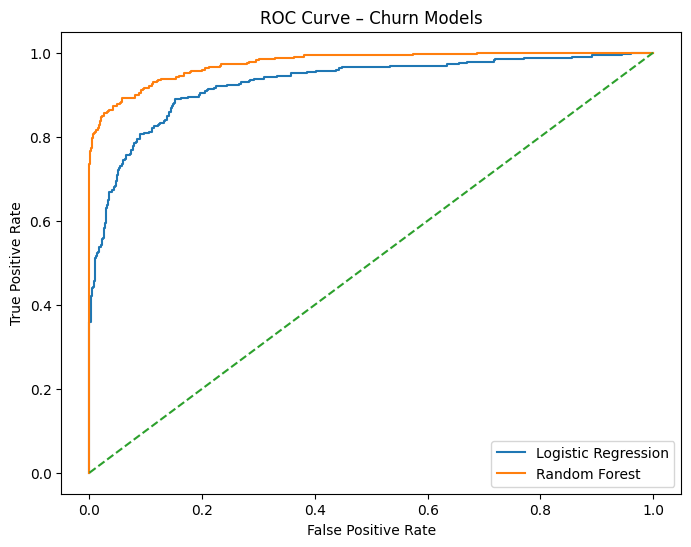

In [18]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Churn Models")
plt.legend()
plt.show()


### Confusion Matrix (Random Forest)

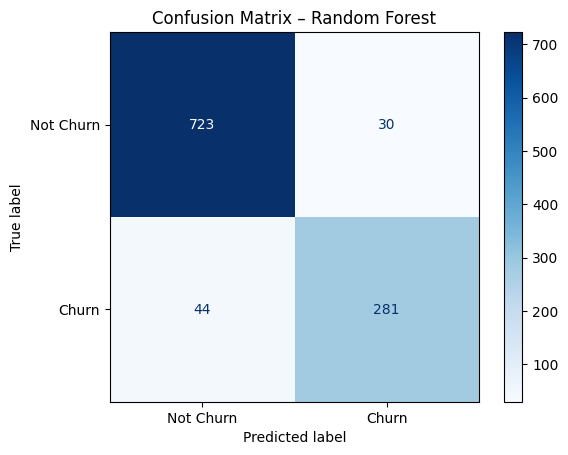

In [19]:
cm = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Churn", "Churn"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.show()


### Random Forest Feature Importance Plot

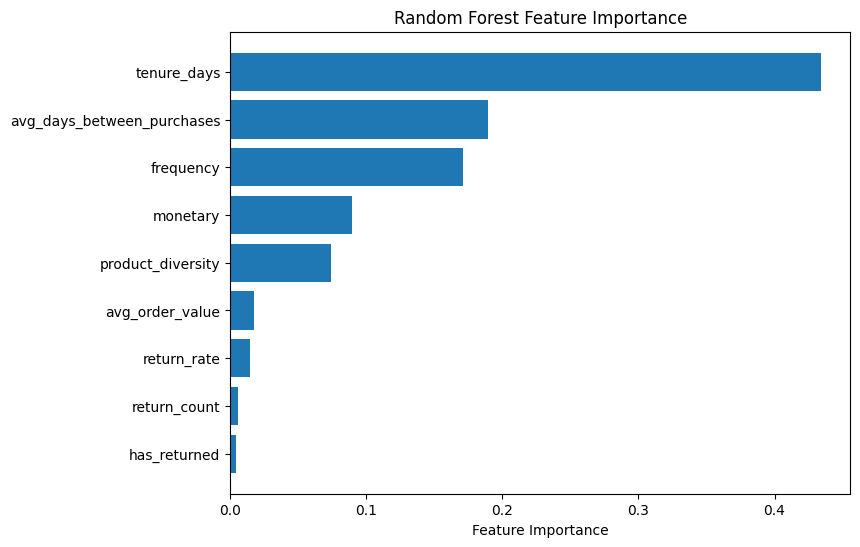

In [20]:
rf_importance_sorted = rf_importance.sort_values(
    by="importance",
    ascending=True
)

plt.figure(figsize=(8, 6))
plt.barh(
    rf_importance_sorted["feature"],
    rf_importance_sorted["importance"]
)

plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()
